# ResNet Transfer Learning with Keras

In this example, we'll use a pretrained convnet to boost the performance on a small dataset. The dataset is taken from the cats vs dogs challenge on [Kaggle](https://www.kaggle.com/c/dogs-vs-cats/data). Using a network pretrained on ImageNet allows us to leverage the learned features from a general task and fine-tune them for the more specific task of identifying cats and dogs. The idea is that a model trained on a large-scale dataset will learn a generic model for the visual world which could be useful even though we are using them for a different task.

If the dataset hasn't been created, first download and extract the Kaggle dataset, then run the following python script from the terminal:
```
python3 make_cats_and_dogs_dataset.py
```

There are varying levels of transfer learning. We can use the pretrained convolutional network as a feature extractor and train a classifier on top of this or we can take a pre-trained network and fine-tune the weights. 

## Feature Extraction
The paper [CNN Features: Off-the-shelf](https://www.cv-foundation.org/openaccess/content_cvpr_workshops_2014/W15/html/Razavian_CNN_Features_Off-the-Shelf_2014_CVPR_paper.html) confirms the effectiveness of pretrained CNNs as a feature extractor for various image recognition tasks. We will follow the approach of this paper in taking and freezing the convolutional base of the pre-trained network, discarding the fully connected layers and retraining a new classifier on the convolutional base.



In [11]:
# select GPU
%env CUDA_VISIBLE_DEVICES=0

from keras.applications.resnet50 import ResNet50
import os

input_shape = (224, 224, 3)

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

env: CUDA_VISIBLE_DEVICES=0


In [10]:
from keras import models
from keras.layers import Flatten, Dense, Dropout

x = resnet.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = models.Model(resnet.input, output)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [14]:
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop

resnet.trainable = False

target_size = (224, 224)
batch_size = 16
learning_rate = 1e-5
epochs=20

train_dir = os.path.join('data', 'cats_and_dogs_small', 'train')
validation_dir = os.path.join('data', 'cats_and_dogs_small', 'validation')

train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=target_size,
                                                   batch_size=batch_size,
                                                   class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                       target_size=target_size,
                                                       batch_size=batch_size,
                                                       class_mode='binary')

model.compile(loss='binary_crossentropy',
             optimizer=RMSprop(lr=learning_rate),
             metrics=['accuracy'])

history = model.fit_generator(train_generator,
                             steps_per_epoch=100,
                             epochs=epochs,
                             validation_data=validation_generator,
                             validation_steps=50,
                             verbose=1)

Found 2001 images belonging to 2 classes.
Found 1005 images belonging to 2 classes.
Epoch 1/20
100/100 [==============================] - 48s 484ms/step - loss: 0.0429 - acc: 0.9856 - val_loss: 0.0304 - val_acc: 0.9912
Epoch 2/20
100/100 [==============================] - 32s 325ms/step - loss: 0.0388 - acc: 0.9894 - val_loss: 0.0266 - val_acc: 0.9912
Epoch 3/20
100/100 [==============================] - 32s 323ms/step - loss: 0.0228 - acc: 0.9919 - val_loss: 0.0468 - val_acc: 0.9888
Epoch 4/20
100/100 [==============================] - 29s 291ms/step - loss: 0.0308 - acc: 0.9912 - val_loss: 0.0336 - val_acc: 0.9888
Epoch 5/20
100/100 [==============================] - 35s 346ms/step - loss: 0.0194 - acc: 0.9937 - val_loss: 0.0356 - val_acc: 0.9900
Epoch 6/20
100/100 [==============================] - 27s 266ms/step - loss: 0.0192 - acc: 0.9919 - val_loss: 0.0385 - val_acc: 0.9900
Epoch 7/20
100/100 [==============================] - 33s 331ms/step - loss: 0.0366 - acc: 0.9881 - val_lo

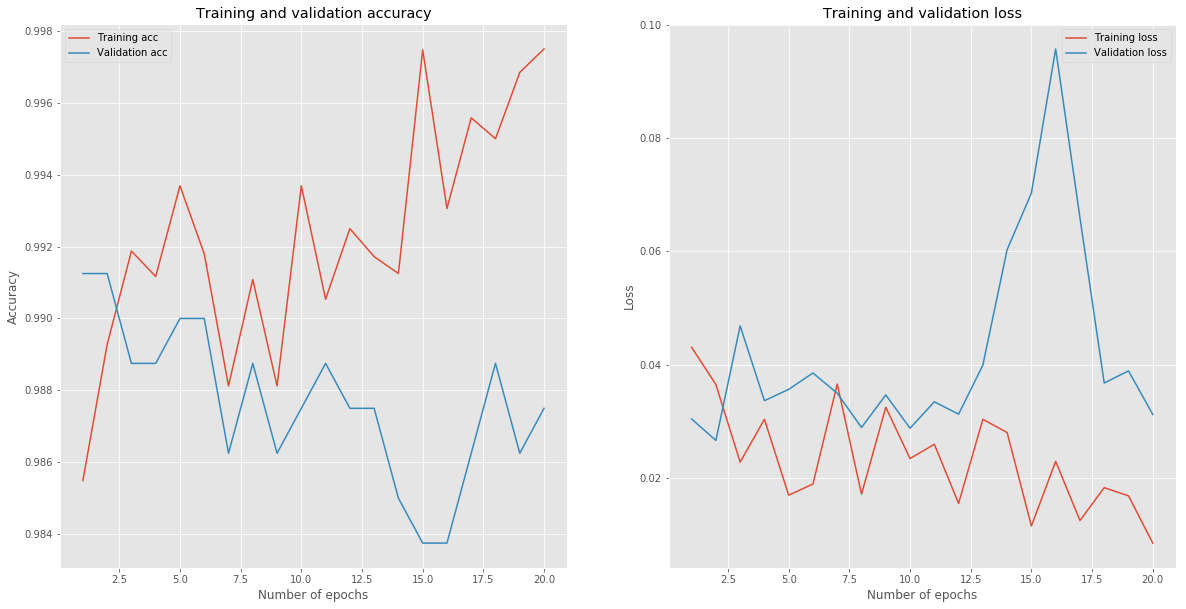

In [36]:
import matplotlib.pyplot as plt

ys = range(1, epochs + 1)

plt.style.use('ggplot')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.plot(ys, history.history['acc'], label='Training acc')
ax1.plot(ys, history.history['val_acc'], label='Validation acc')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Number of epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(ys, history.history['loss'], label='Training loss')
ax2.plot(ys, history.history['val_loss'], label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Number of epochs')
ax2.set_ylabel('Loss')
ax2.legend()


plt.show()

In [20]:
model.save('models/resnet-cats-dogs-classifier.hdf5')

In [17]:
test_dir = os.path.join('data', 'cats_and_dogs_small', 'test')
test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size=target_size,
                                                 batch_size=batch_size,
                                                 class_mode='binary')

metrics = model.evaluate_generator(test_generator)

for i, metric in enumerate(metrics):
    print(model.metrics_names[i], ': ', metric)

Found 1000 images belonging to 2 classes.
loss :  0.08899687083769822
acc :  0.976


In [29]:
predictions = model.predict_generator(test_generator)

In [44]:
validation_generator.class_indices

{'cats': 0, 'dogs': 1}